### For this assignment, we will:
- Load the houseprices data from Thinkful's database.
- Reimplement the model you built in the previous checkpoint.
- Check for all of the assumptions above and discuss the implications if some of the assumptions are not met.

### Gauss Markov Conditions:

- linearity of models in their coefficients
- the error term should be zero on average
- homoscedasticity
- low multicollinearity
- error terms should be uncorrelated with one another
- features shouldn't be correlated with the errors
- normality of the errors

In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


house_df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000


In [2]:
# Clean the data set before starting analysis

def remove_null_cols(df):
    n = len(df)
    cols = df.columns
    null_cols = [(len(df[df[col].isnull()]) == 0) for col in df]
    return df.iloc[:, null_cols]
    
house_df = remove_null_cols(house_df)

In [3]:
# We need to convert categorical non-numerical columns into numerical columns
non_numeric_columns = house_df.select_dtypes(['object']).columns
print(non_numeric_columns)
print("The number of non-numerical columns is {}".format(len(non_numeric_columns)))

Index(['mszoning', 'street', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'exterqual', 'extercond', 'foundation', 'heating',
       'heatingqc', 'centralair', 'kitchenqual', 'functional', 'paveddrive',
       'saletype', 'salecondition'],
      dtype='object')
The number of non-numerical columns is 27


In [4]:
# Count number of numerical columns as well
numeric_columns = house_df.select_dtypes(['int64', 'float64']).columns
print(numeric_columns)
print("The number of numerical columns is {}".format(len(numeric_columns)))

Index(['id', 'mssubclass', 'lotarea', 'overallqual', 'overallcond',
       'yearbuilt', 'yearremodadd', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf',
       'totalbsmtsf', 'firstflrsf', 'secondflrsf', 'lowqualfinsf', 'grlivarea',
       'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr',
       'kitchenabvgr', 'totrmsabvgrd', 'fireplaces', 'garagecars',
       'garagearea', 'wooddecksf', 'openporchsf', 'enclosedporch',
       'threessnporch', 'screenporch', 'poolarea', 'miscval', 'mosold',
       'yrsold', 'saleprice'],
      dtype='object')
The number of numerical columns is 35


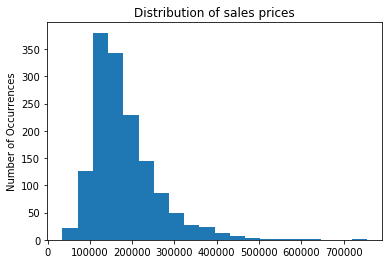

In [5]:
# Plot distribution for target variable
plt.hist(house_df.saleprice, bins=20)
plt.title("Distribution of sales prices")
plt.ylabel("Number of Occurrences")
plt.show()

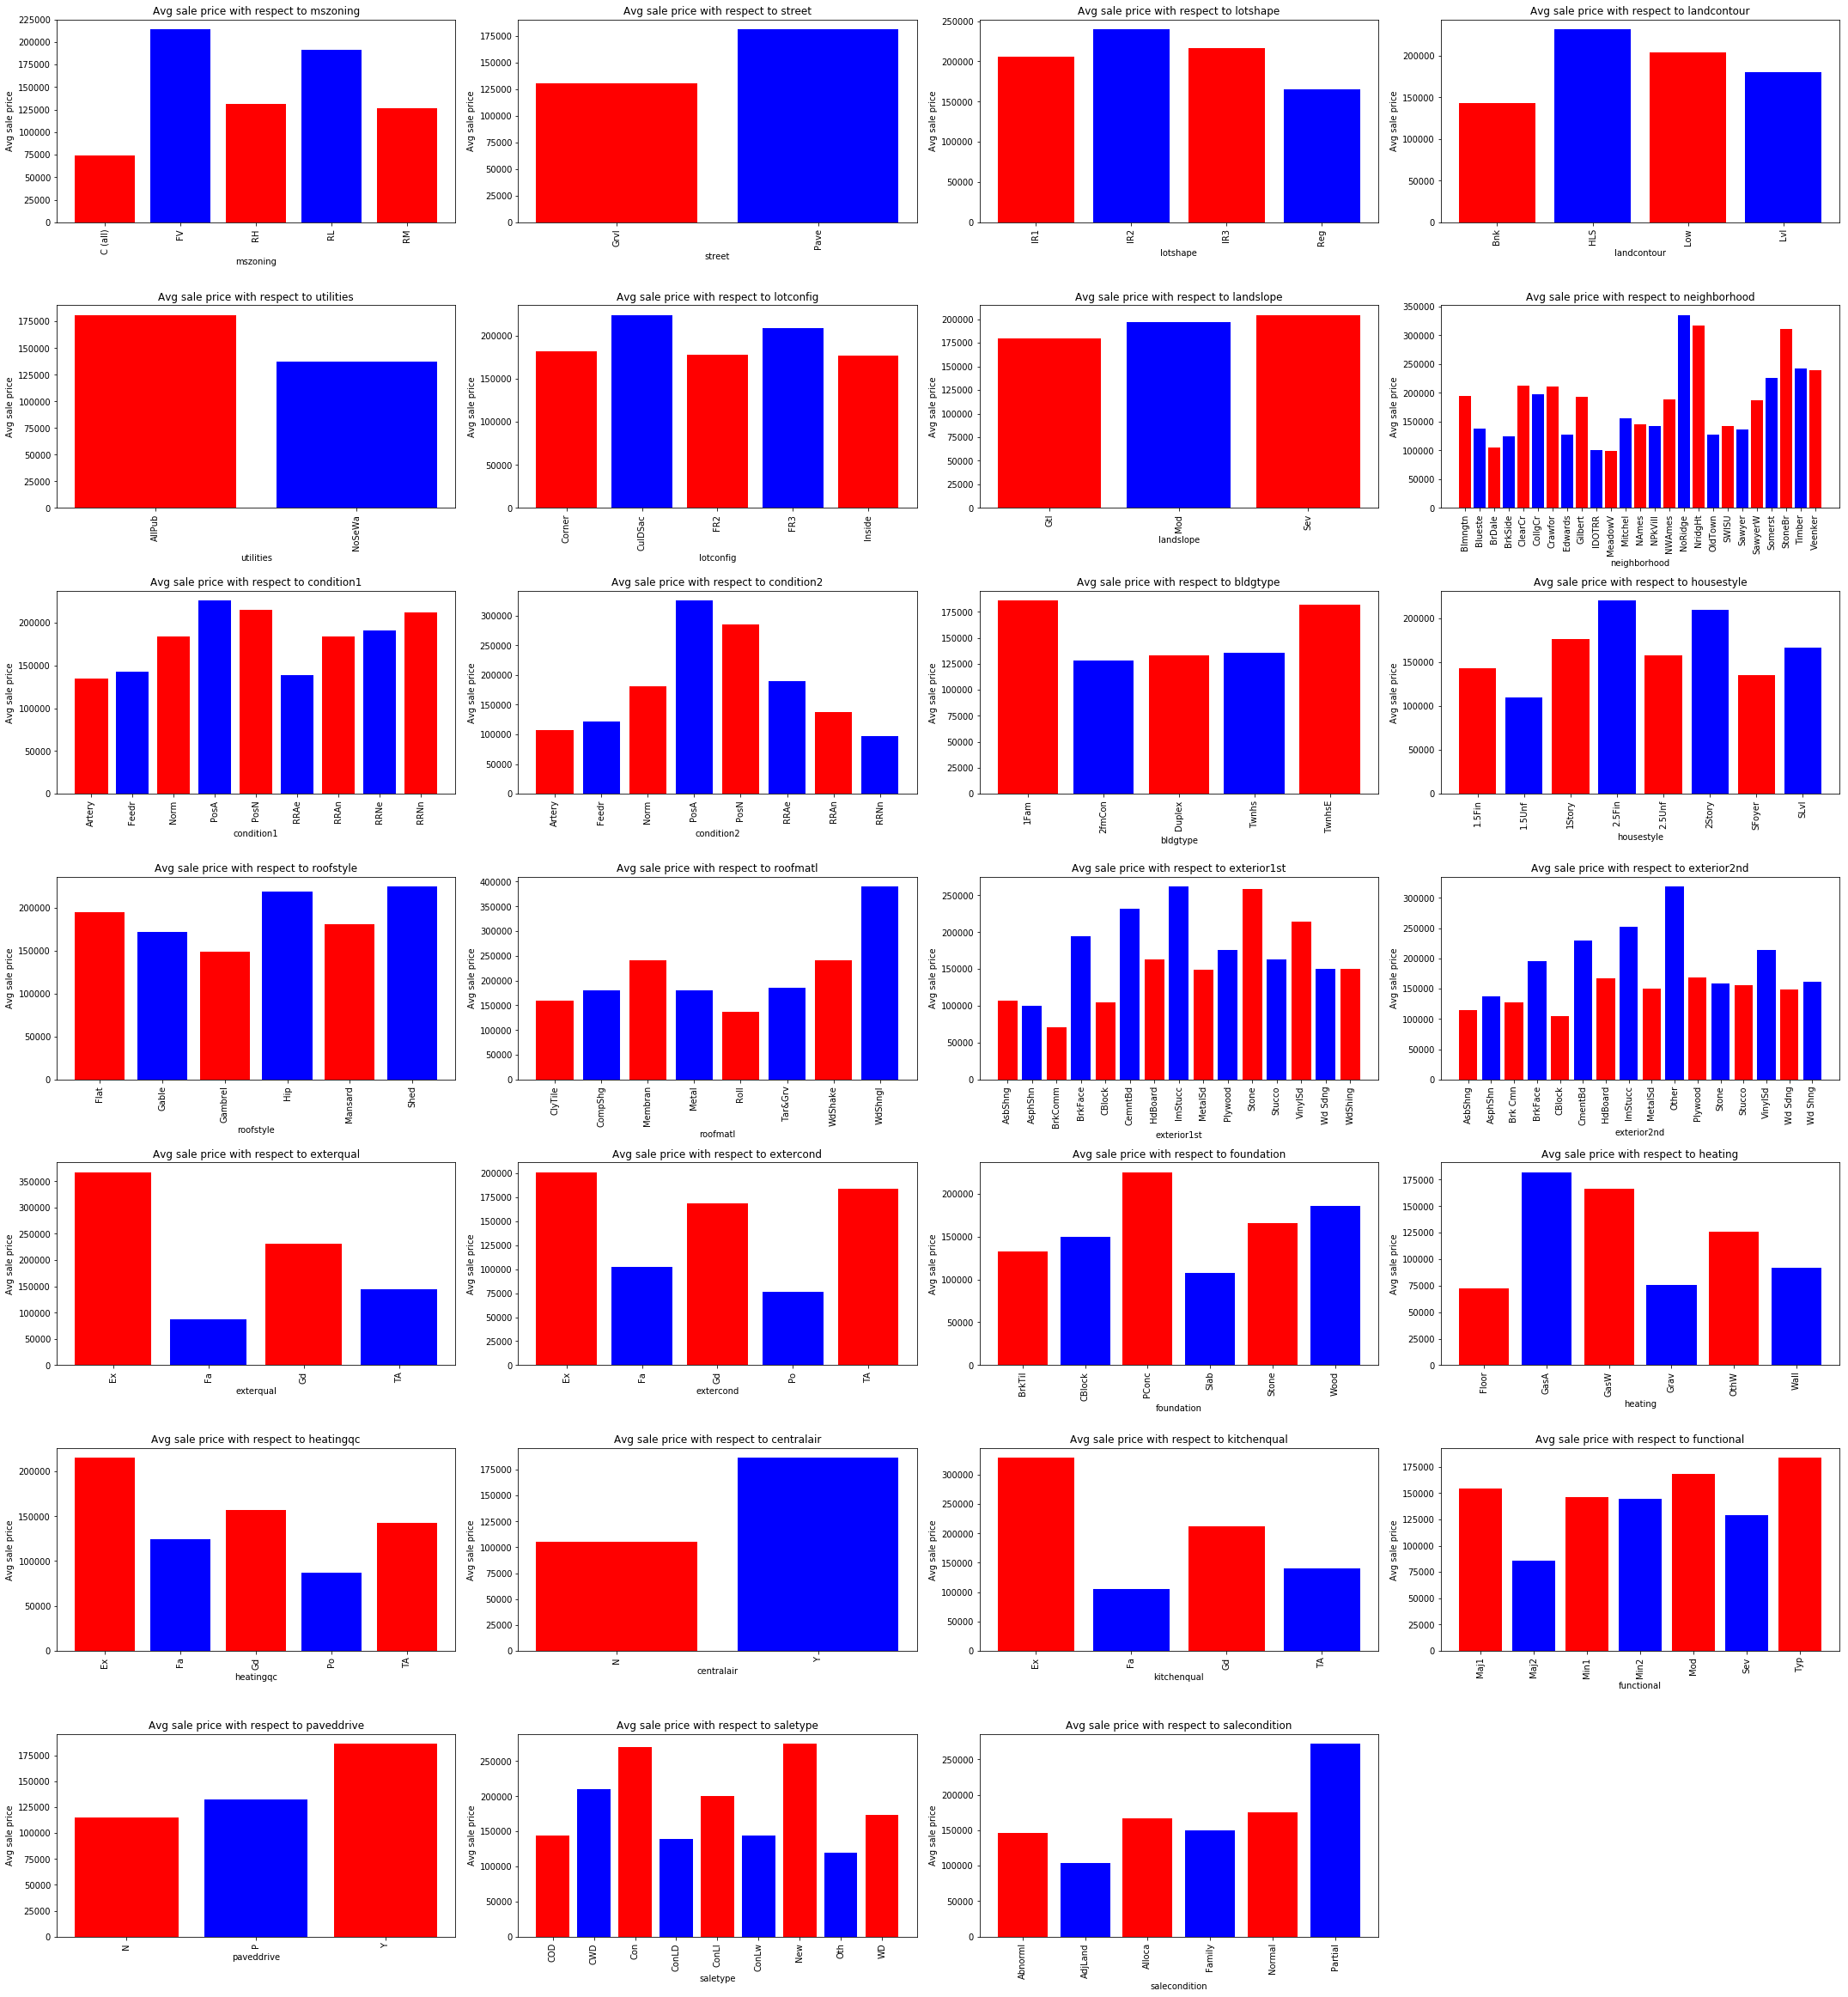

In [6]:
# Plot each feature against the target variable to understand the univariate relation between the target variable
# and non-numerical features

# Shown below are the average sale prices with respect to the each category of a feature

plt.figure(figsize=(30,50))

for index, column in enumerate(non_numeric_columns):
    plt.subplot(11,4,index+1)
    plt.bar(house_df.groupby(column)["saleprice"].mean().index, house_df.groupby(column)["saleprice"].mean(),
           color=("red","blue"))
    plt.title("Avg sale price with respect to {}".format(column))
    plt.ylabel("Avg sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

In [7]:
# Convert chosen variables to dummy variables so we can use in our model
house_df = pd.concat([house_df,pd.get_dummies(house_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
house_df = pd.concat([house_df,pd.get_dummies(house_df.street, prefix="street", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(house_df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(house_df.street, prefix="street", drop_first=True).columns)

In [8]:
X = house_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf', 'firstflrsf'] + dummy_column_names]
Y = house_df.saleprice

X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     438.6
Date:                Thu, 01 Aug 2019   Prob (F-statistic):               0.00
Time:                        17:57:02   Log-Likelihood:                -17474.
No. Observations:                1460   AIC:                         3.497e+04
Df Residuals:                    1448   BIC:                         3.504e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.189e+05   1.81e+04     -6.579      0.000   -1.54e+05   -8.35e+04
overallqual  2.352e+04   1097.295     21.435      0.000    2.14e+04    2.57e+04
grlivarea      44.2811      2.655     16.676      0.000      39.072      49.490
garagecars   1.348e+04   2989.636      4.511      0.000    7620.477    1.93e+04
garagearea     15.3485     10.427      1.472      0.141      -5.106      35.803
totalbsmtsf    24.1179      4.263      5.658      0.000      15.756      32.480
firstflrsf      6.9558      5.052      1.377      0.169      -2.953      16.865
mszoning_FV  2.501e+04   1.37e+04      1.828      0.068   -1833.870    5.18e+04
mszoning_RH  1.251e+04   1.59e+04      0.789      0.430   -1.86e+04    4.36e+04
mszoning_RL  2.748e+04   1.27e+04      2.157      0.031    2486.925    5.25e+04
mszoning_RM  8448.3602   1.29e+04      0.655      0.512   -1.68e+04    3.37e+04
street_Pave   448.6972   1.63e+04      0.028      0.978   -3.15e+04    3.24e+04
==============================================================================
Omnibus:                      413.945   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            40487.648
Skew:                          -0.106   Prob(JB):                         0.00
Kurtosis:                      28.797   Cond. No.                     6.46e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.46e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Assumption one: linearity of the model in its coefficients
The target variable should be a linear function of the model's coefficients

In [13]:
# Y is the target variable
Y = house_df['saleprice']
# X is the feature set which includes
# is_male and is_smoker variables
X = house_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf', 'firstflrsf'] + dummy_column_names]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [2.35209921e+04 4.42810775e+01 1.34849581e+04 1.53485226e+01
 2.41179324e+01 6.95576980e+00 2.50072844e+04 1.25084966e+04
 2.74802011e+04 8.44836024e+03 4.48697237e+02]

Intercept: 
 -118949.14064945703


## Assumption two: the error term should be zero on average
This second assumption states that the expected value of the error term should be zero.

In [15]:
predictions = lrm.predict(X)
errors = np.array(Y) - predictions

print("The mean of the errors in the housing cost model is: {}".format(np.mean(errors)))

print('This number is essentially zero, so assumption 2 is met.')

The mean of the errors in the housing cost model is: -1.4033627836671595e-11
This number is essentially zero, so assumption 2 is met.


## Assumption three: homoscedasticity
A model is homoscedastic when the distribution of its error terms (known as "scedasticity") is consistent for all predicted values. This means that the error variance shouldn't systematically change across observations. When this assumption is not met, we are dealing with heteroscedasticity.

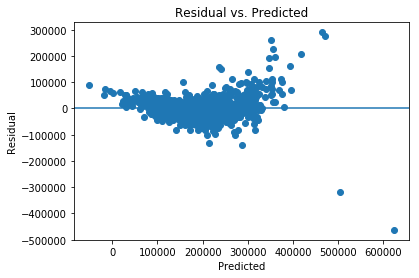

In [17]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

This plot of the predictions vs errors does not imply homoscedasticity.

In [16]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 499.089 and p value is 1.5e-110
Levene test statistic value is 493.01 and p value is 4.7e-101


The p-values of both tests are lower than 0.05. So, the test results reject the null hypothesis which means our errors are heteroscedastic. So both our tests show the model is heteroscedastic, meaning that the accuracy of our estimations are not very reliable and condition 3 is not met.

## Assumption four: low multicollinearity
Individual features should be only weakly correlated with one another, and ideally completely uncorrelated. When features are correlated, they may both explain the same pattern of variance in the outcome. The model will attempt to find a solution, potentially by attributing half the explanatory power to one feature and half to the other. Multicollinearity can cause us to underestimate the relationship between features and outcomes, which can be harmful if we want to know which features matter most when predicting an outcome.

In [18]:
X.corr()

,overallqual,grlivarea,garagecars,garagearea,totalbsmtsf,firstflrsf,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Pave
overallqual,1.000000,0.593007,0.600671,0.562022,0.537808,0.476224,0.171854,-0.064666,0.126972,-0.195515,0.058823
grlivarea,0.593007,1.000000,0.467247,0.468997,0.454868,0.566024,0.024275,-0.001070,0.132936,-0.154239,0.044121
garagecars,0.600671,0.467247,1.000000,0.882475,0.434585,0.439317,0.102851,-0.090477,0.175167,-0.221834,-0.020025
garagearea,0.562022,0.468997,0.882475,1.000000,0.486665,0.489782,0.114859,-0.073188,0.169593,-0.235580,-0.047794
totalbsmtsf,0.537808,0.454868,0.434585,0.486665,1.000000,0.819530,-0.032689,-0.055128,0.257373,-0.247379,0.005068
firstflrsf,0.476224,0.566024,0.439317,0.489782,0.819530,1.000000,-0.095486,-0.039343,0.304731,-0.267029,0.005950
mszoning_FV,0.171854,0.024275,0.102851,0.114859,-0.032689,-0.095486,1.000000,-0.022722,-0.416608,-0.090435,0.013866
mszoning_RH,-0.064666,-0.001070,-0.090477,-0.073188,-0.055128,-0.039343,-0.022722,1.000000,-0.203158,-0.044101,0.006762
mszoning_RL,0.126972,0.132936,0.175167,0.169593,0.257373,0.304731,-0.416608,-0.203158,1.000000,-0.808585,0.045348
mszoning_RM,-0.195515,-0.154239,-0.221834,-0.235580,-0.247379,-0.267029,-0.090435,-0.044101,-0.808585,1.000000,-0.003127


We have some highly correlated features like garagearea and garagecars, mszoning_RL and mszoning_RM, totalbsmtsf and firstflrsf. We can easily solve this issue by dropping one of the strongly correlated variables from the model.

## Assumption five: error terms should be uncorrelated with one another
The error term for one observation shouldn't predict the error term for another. This type of serial correlation may happen if we omit a relevant variable from the model. 

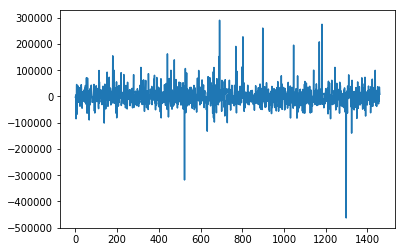

In [19]:
plt.plot(errors)
plt.show()

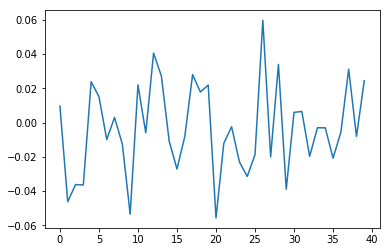

In [20]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

The graphs above show that the error terms are uncorrelated with each other, so condition 5 is met.

## Assumption six: features shouldn't be correlated with the errors
Explanatory variables and errors should be independent. If this assumption doesn't hold, then the model's predictions will be unreliable as the estimates of the coefficients would be biased. This assumption is known as the exogeneity. Common causes of exogeneity violations are omitted variables and simultaneous causation between independent variables and the target. 

In [21]:
df = pd.concat([X, pd.DataFrame(errors, columns=["error"])], axis=1)
df.corr().iloc[:,-1:]

,error
overallqual,-1.610757e-15
grlivarea,6.722100e-16
garagecars,3.952337e-15
garagearea,4.471734e-15
totalbsmtsf,-1.465261e-14
firstflrsf,-9.720072e-15
mszoning_FV,2.522294e-15
mszoning_RH,3.458950e-16
mszoning_RL,-3.204080e-15
mszoning_RM,1.939512e-15


The table above shows that the features and errors are not correlated, i.e. independent. Condition 6 is met.

## A very important remark on the normality of the errors
This is not an assumption of OLS, but it still can impact our results. Normality of errors is not required to apply OLS to a linear regression model, but in order to measure the statistical significance of our estimated coefficients, error terms must be normally distributed.

Non-normally distributed errors usually stem from omitted variables. Including the omitted relevant features to the model may help fix the issue. Sometimes, transforming the dependent variable also helps.

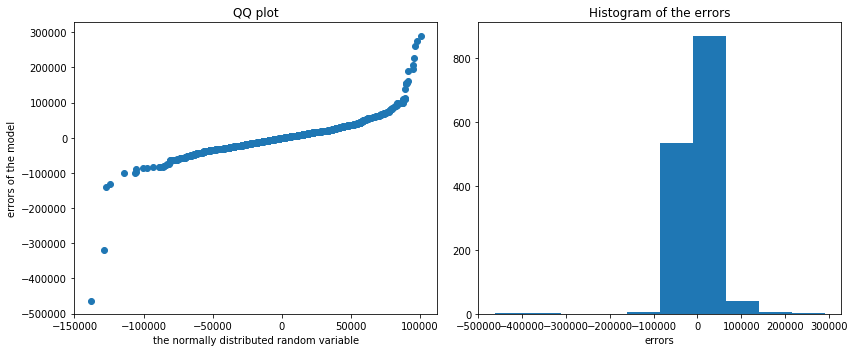

In [22]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

In [24]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 40487.648308622585 and p value is 0.0
Normality test statistics is 413.9446777361201 and p value is 1.2973445238525048e-90


These normality tests and graphs shown above indicate that the errors of the model are not distributed normally. This means that the test statistics for the coefficients are problematic.